# Phase 3: ML Model Training & Evaluation

**Project:** Predictive Modeling of I/O Performance for ML Training Pipelines

**Phase 3 Objectives:**
1. Build regression models to predict I/O throughput
2. Build classification models to recommend optimal configurations
3. Evaluate models using cross-validation
4. Compare multiple algorithms (Linear, Ensemble, Neural Networks)
5. Perform hyperparameter tuning
6. Analyze feature importance

**Research Questions:**
- Can ML models accurately predict I/O throughput (RMSE, R²)?
- Which algorithms perform best for this systems optimization problem?
- What are the key performance drivers (feature importance)?

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

# Regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb

# Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Visualization
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Libraries imported successfully")
print(f"XGBoost version: {xgb.__version__}")

✅ Libraries imported successfully
XGBoost version: 3.1.1


## 1. Load and Prepare Data

Load the preprocessed dataset from Phase 2.

In [2]:
# Load preprocessed data
data_path = Path('../results/ml_dataset/preprocessed_data.csv')
df = pd.read_csv(data_path)

print("📊 Dataset Overview")
print("="*60)
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\nTarget variable: target_throughput")
print(f"Range: {df['target_throughput'].min():.2f} - {df['target_throughput'].max():.2f}")
print(f"\nBenchmark types: {df['benchmark_type'].unique()}")

df.head()

📊 Dataset Overview
Shape: (141, 13)
Columns: ['block_kb', 'file_size_mb', 'n_samples', 'throughput_mb_s', 'iops', 'n_threads', 'aggregate_throughput_mb_s', 'batch_size', 'samples_per_second', 'data_loading_ratio', 'num_workers', 'target_throughput', 'benchmark_type']

Target variable: target_throughput
Range: 1.10 - 48210.99

Benchmark types: ['io_random' 'io_concurrent' 'training']


,block_kb,file_size_mb,n_samples,throughput_mb_s,iops,n_threads,aggregate_throughput_mb_s,batch_size,samples_per_second,data_loading_ratio,num_workers,target_throughput,benchmark_type
0,-0.773432,-0.610499,-1.475012,-1.500378,-0.269612,-0.092458,0.076162,0.0,-0.341731,-0.217801,0.0,11.017317,io_random
1,-0.773432,-0.610499,-0.069764,-0.827980,0.385664,-0.092458,0.076162,0.0,-0.341731,-0.217801,0.0,1975.411764,io_random
2,-0.773432,-0.610499,1.686796,-0.835087,0.974369,-0.092458,0.076162,0.0,-0.341731,-0.217801,0.0,1954.647022,io_random
3,-0.625662,-0.610499,-1.475012,-0.280600,-0.119341,-0.092458,0.076162,0.0,-0.341731,-0.217801,0.0,3574.568666,io_random
4,-0.625662,-0.610499,-0.069764,-0.290552,0.731937,-0.092458,0.076162,0.0,-0.341731,-0.217801,0.0,3545.494439,io_random


In [3]:
# Prepare features and target
# Exclude target and categorical columns from features
feature_cols = [col for col in df.columns if col not in ['target_throughput', 'benchmark_type']]
X = df[feature_cols].values
y = df['target_throughput'].values

# Apply log transformation to target (from Phase 2 recommendation)
y_log = np.log1p(y)  # log(1 + y) to handle zeros

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature names: {feature_cols}")
print(f"\nTarget statistics (original):")
print(f"  Mean: {y.mean():.2f}, Std: {y.std():.2f}")
print(f"\nTarget statistics (log-transformed):")
print(f"  Mean: {y_log.mean():.2f}, Std: {y_log.std():.2f}")

Features shape: (141, 11)
Target shape: (141,)

Feature names: ['block_kb', 'file_size_mb', 'n_samples', 'throughput_mb_s', 'iops', 'n_threads', 'aggregate_throughput_mb_s', 'batch_size', 'samples_per_second', 'data_loading_ratio', 'num_workers']

Target statistics (original):
  Mean: 6221.11, Std: 7603.43

Target statistics (log-transformed):
  Mean: 7.45, Std: 2.32


In [4]:
# Train-test split
test_size = 0.2
random_state = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=test_size, random_state=random_state
)

print(f"📊 Train-Test Split (test_size={test_size})")
print("="*60)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Feature dimensions: {X_train.shape[1]}")

📊 Train-Test Split (test_size=0.2)
Training set: 112 samples
Test set: 29 samples
Feature dimensions: 11


## 2. Baseline Models - Linear Regression

Start with simple linear models as baselines.

In [5]:
# Train baseline linear regression
print("🔧 Training Linear Regression Models")
print("="*60)

models = {
    'Linear Regression': LinearRegression(),
    'Ridge (α=1.0)': Ridge(alpha=1.0, random_state=random_state),
    'Lasso (α=0.1)': Lasso(alpha=0.1, random_state=random_state),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=random_state)
}

results = {}

for name, model in models.items():
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Evaluate
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    test_mae = mean_absolute_error(y_test, y_pred_test)
    
    results[name] = {
        'train_r2': train_r2,
        'test_r2': test_r2,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'model': model
    }
    
    print(f"\n{name}:")
    print(f"  Train R²: {train_r2:.4f}")
    print(f"  Test R²:  {test_r2:.4f}")
    print(f"  Test RMSE: {test_rmse:.4f}")
    print(f"  Test MAE:  {test_mae:.4f}")

print("\n✅ Linear models trained")

🔧 Training Linear Regression Models

Linear Regression:
  Train R²: 0.7965
  Test R²:  0.6051
  Test RMSE: 1.4570
  Test MAE:  0.9721



Ridge (α=1.0):
  Train R²: 0.7963
  Test R²:  0.6130
  Test RMSE: 1.4425
  Test MAE:  0.9511

Lasso (α=0.1):
  Train R²: 0.7663
  Test R²:  0.6906
  Test RMSE: 1.2898
  Test MAE:  0.7678

ElasticNet:
  Train R²: 0.7786
  Test R²:  0.6739
  Test RMSE: 1.3241
  Test MAE:  0.7997

✅ Linear models trained


## 3. Ensemble Models - Random Forest & XGBoost

Train ensemble methods for better performance.

In [6]:
# Random Forest
print("🌲 Training Random Forest Regressor")
print("="*60)

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=random_state,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

y_pred_train_rf = rf_model.predict(X_train)
y_pred_test_rf = rf_model.predict(X_test)

rf_train_r2 = r2_score(y_train, y_pred_train_rf)
rf_test_r2 = r2_score(y_test, y_pred_test_rf)
rf_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test_rf))
rf_test_mae = mean_absolute_error(y_test, y_pred_test_rf)

results['Random Forest'] = {
    'train_r2': rf_train_r2,
    'test_r2': rf_test_r2,
    'test_rmse': rf_test_rmse,
    'test_mae': rf_test_mae,
    'model': rf_model
}

print(f"Train R²: {rf_train_r2:.4f}")
print(f"Test R²:  {rf_test_r2:.4f}")
print(f"Test RMSE: {rf_test_rmse:.4f}")
print(f"Test MAE:  {rf_test_mae:.4f}")

🌲 Training Random Forest Regressor


Train R²: 0.9952
Test R²:  0.9836
Test RMSE: 0.2967
Test MAE:  0.1447


In [7]:
# XGBoost
print("\n⚡ Training XGBoost Regressor")
print("="*60)

xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=random_state,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

y_pred_train_xgb = xgb_model.predict(X_train)
y_pred_test_xgb = xgb_model.predict(X_test)

xgb_train_r2 = r2_score(y_train, y_pred_train_xgb)
xgb_test_r2 = r2_score(y_test, y_pred_test_xgb)
xgb_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test_xgb))
xgb_test_mae = mean_absolute_error(y_test, y_pred_test_xgb)

results['XGBoost'] = {
    'train_r2': xgb_train_r2,
    'test_r2': xgb_test_r2,
    'test_rmse': xgb_test_rmse,
    'test_mae': xgb_test_mae,
    'model': xgb_model
}

print(f"Train R²: {xgb_train_r2:.4f}")
print(f"Test R²:  {xgb_test_r2:.4f}")
print(f"Test RMSE: {xgb_test_rmse:.4f}")
print(f"Test MAE:  {xgb_test_mae:.4f}")


⚡ Training XGBoost Regressor
Train R²: 0.9998
Test R²:  0.9911
Test RMSE: 0.2193
Test MAE:  0.1342


## 4. Neural Network Model

Train a Multi-Layer Perceptron (MLP) for comparison.

In [8]:
# MLP Regressor
print("🧠 Training Neural Network (MLP)")
print("="*60)

mlp_model = MLPRegressor(
    hidden_layer_sizes=(64, 32, 16),
    activation='relu',
    solver='adam',
    alpha=0.001,
    batch_size='auto',
    learning_rate='adaptive',
    max_iter=500,
    random_state=random_state,
    early_stopping=True,
    validation_fraction=0.1
)

mlp_model.fit(X_train, y_train)

y_pred_train_mlp = mlp_model.predict(X_train)
y_pred_test_mlp = mlp_model.predict(X_test)

mlp_train_r2 = r2_score(y_train, y_pred_train_mlp)
mlp_test_r2 = r2_score(y_test, y_pred_test_mlp)
mlp_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test_mlp))
mlp_test_mae = mean_absolute_error(y_test, y_pred_test_mlp)

results['Neural Network (MLP)'] = {
    'train_r2': mlp_train_r2,
    'test_r2': mlp_test_r2,
    'test_rmse': mlp_test_rmse,
    'test_mae': mlp_test_mae,
    'model': mlp_model
}

print(f"Train R²: {mlp_train_r2:.4f}")
print(f"Test R²:  {mlp_test_r2:.4f}")
print(f"Test RMSE: {mlp_test_rmse:.4f}")
print(f"Test MAE:  {mlp_test_mae:.4f}")
print(f"\nIterations: {mlp_model.n_iter_}")

🧠 Training Neural Network (MLP)


Train R²: 0.9570
Test R²:  0.1367
Test RMSE: 2.1543
Test MAE:  0.9764

Iterations: 500


## 5. Model Comparison

Compare all models and visualize results.

In [9]:
# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train R²': [results[m]['train_r2'] for m in results.keys()],
    'Test R²': [results[m]['test_r2'] for m in results.keys()],
    'Test RMSE': [results[m]['test_rmse'] for m in results.keys()],
    'Test MAE': [results[m]['test_mae'] for m in results.keys()]
})

comparison_df = comparison_df.sort_values('Test R²', ascending=False)

print("\n📊 MODEL COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))
print("\n" + "="*80)

best_model_name = comparison_df.iloc[0]['Model']
best_r2 = comparison_df.iloc[0]['Test R²']
print(f"\n🏆 Best Model: {best_model_name} (Test R² = {best_r2:.4f})")


📊 MODEL COMPARISON
               Model  Train R²  Test R²  Test RMSE  Test MAE
             XGBoost  0.999795 0.991052   0.219338  0.134193
       Random Forest  0.995183 0.983629   0.296676  0.144701
       Lasso (α=0.1)  0.766272 0.690568   1.289815  0.767826
          ElasticNet  0.778628 0.673908   1.324080  0.799716
       Ridge (α=1.0)  0.796257 0.612995   1.442456  0.951143
   Linear Regression  0.796455 0.605134   1.457033  0.972134
Neural Network (MLP)  0.957011 0.136738   2.154347  0.976389


🏆 Best Model: XGBoost (Test R² = 0.9911)


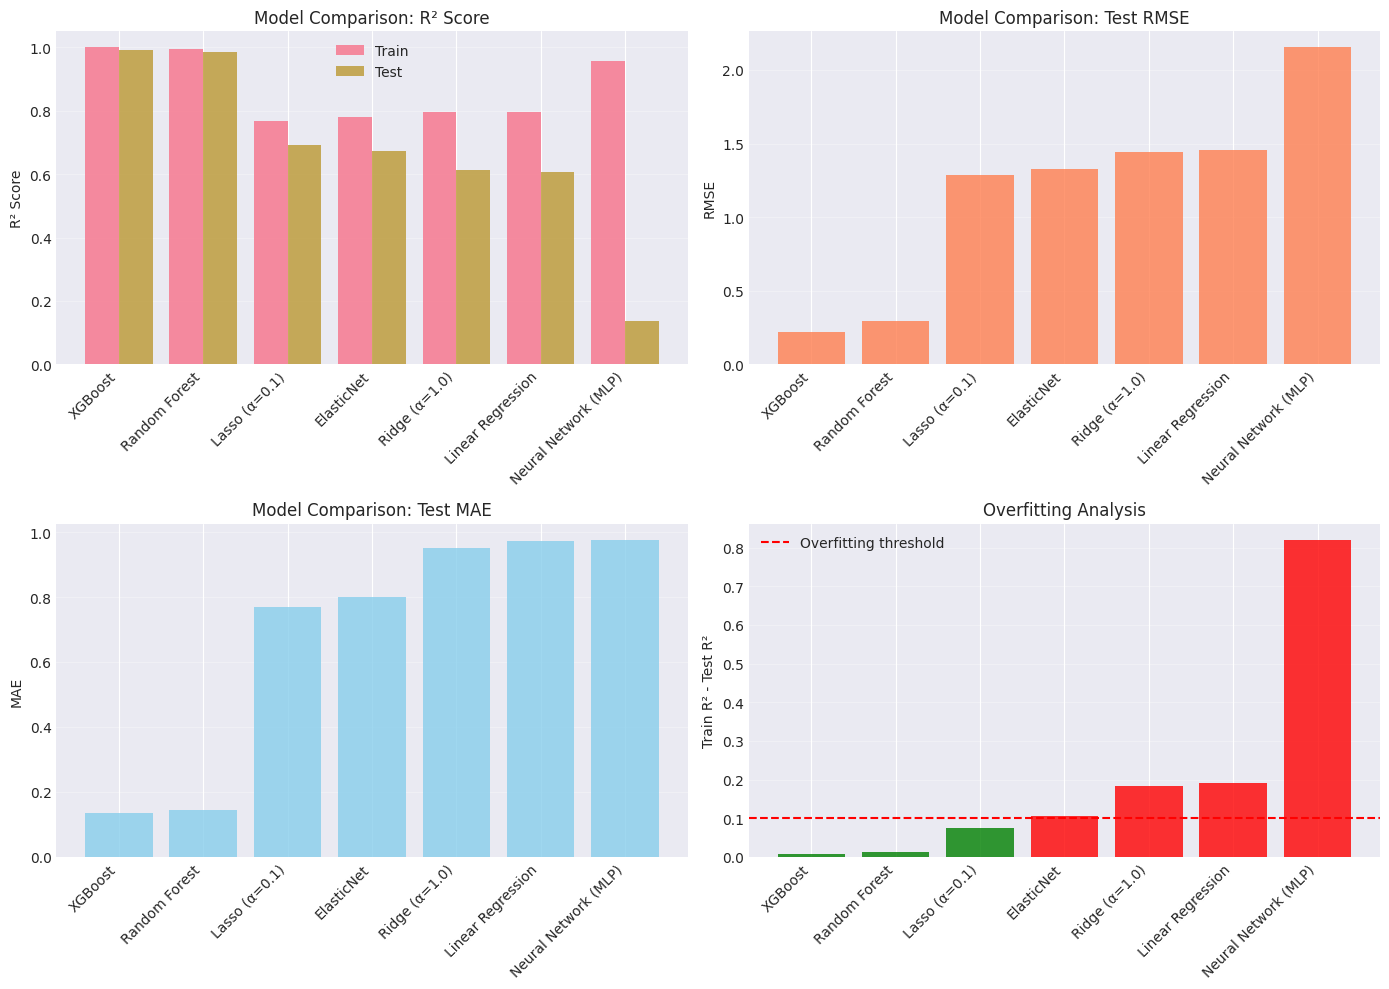

In [10]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# R² comparison
ax1 = axes[0, 0]
x_pos = np.arange(len(comparison_df))
ax1.bar(x_pos - 0.2, comparison_df['Train R²'], 0.4, label='Train', alpha=0.8)
ax1.bar(x_pos + 0.2, comparison_df['Test R²'], 0.4, label='Test', alpha=0.8)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
ax1.set_ylabel('R² Score')
ax1.set_title('Model Comparison: R² Score')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# RMSE comparison
ax2 = axes[0, 1]
ax2.bar(comparison_df['Model'], comparison_df['Test RMSE'], color='coral', alpha=0.8)
ax2.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
ax2.set_ylabel('RMSE')
ax2.set_title('Model Comparison: Test RMSE')
ax2.grid(axis='y', alpha=0.3)

# MAE comparison
ax3 = axes[1, 0]
ax3.bar(comparison_df['Model'], comparison_df['Test MAE'], color='skyblue', alpha=0.8)
ax3.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
ax3.set_ylabel('MAE')
ax3.set_title('Model Comparison: Test MAE')
ax3.grid(axis='y', alpha=0.3)

# Overfitting check (Train R² - Test R²)
ax4 = axes[1, 1]
overfitting = comparison_df['Train R²'] - comparison_df['Test R²']
colors = ['red' if x > 0.1 else 'green' for x in overfitting]
ax4.bar(comparison_df['Model'], overfitting, color=colors, alpha=0.8)
ax4.axhline(y=0.1, color='red', linestyle='--', label='Overfitting threshold')
ax4.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
ax4.set_ylabel('Train R² - Test R²')
ax4.set_title('Overfitting Analysis')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Cross-Validation

Perform 5-fold cross-validation for robust evaluation.

In [11]:
# 5-fold cross-validation
print("🔄 Performing 5-Fold Cross-Validation")
print("="*60)

cv = KFold(n_splits=5, shuffle=True, random_state=random_state)
cv_results = {}

# Select top 3 models for CV (to save time)
top_models = comparison_df.head(3)['Model'].tolist()

for model_name in top_models:
    model = results[model_name]['model']
    
    # Cross-validation scores
    cv_scores = cross_val_score(
        model, X_train, y_train, 
        cv=cv, 
        scoring='r2',
        n_jobs=-1
    )
    
    cv_results[model_name] = {
        'mean': cv_scores.mean(),
        'std': cv_scores.std(),
        'scores': cv_scores
    }
    
    print(f"\n{model_name}:")
    print(f"  CV R² scores: {cv_scores}")
    print(f"  Mean CV R²: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

print("\n✅ Cross-validation complete")

🔄 Performing 5-Fold Cross-Validation



XGBoost:
  CV R² scores: [0.93876505 0.95440464 0.98019494 0.98053266 0.9739319 ]
  Mean CV R²: 0.9656 (+/- 0.0329)



Random Forest:
  CV R² scores: [0.97021412 0.96643076 0.97919386 0.99368988 0.9857532 ]
  Mean CV R²: 0.9791 (+/- 0.0199)

Lasso (α=0.1):
  CV R² scores: [0.7113739  0.60786145 0.7897463  0.69869895 0.71695071]
  Mean CV R²: 0.7049 (+/- 0.1161)

✅ Cross-validation complete


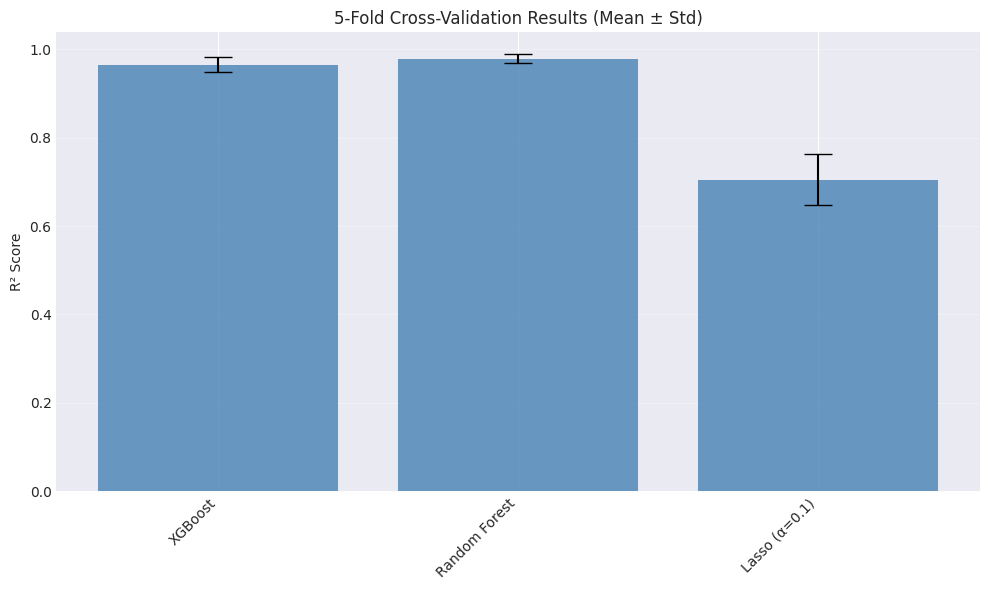

In [12]:
# Visualize CV results
fig, ax = plt.subplots(figsize=(10, 6))

cv_means = [cv_results[m]['mean'] for m in cv_results.keys()]
cv_stds = [cv_results[m]['std'] for m in cv_results.keys()]
models = list(cv_results.keys())

x_pos = np.arange(len(models))
ax.bar(x_pos, cv_means, yerr=cv_stds, alpha=0.8, capsize=10, color='steelblue')
ax.set_xticks(x_pos)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.set_ylabel('R² Score')
ax.set_title('5-Fold Cross-Validation Results (Mean ± Std)')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Feature Importance Analysis

Analyze which features are most important for predictions.

In [13]:
# Feature importance from tree-based models
print("🔍 Feature Importance Analysis")
print("="*60)

# Random Forest feature importance
rf_importances = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nRandom Forest Feature Importance:")
print(rf_importances.to_string(index=False))

# XGBoost feature importance
xgb_importances = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n\nXGBoost Feature Importance:")
print(xgb_importances.to_string(index=False))

🔍 Feature Importance Analysis

Random Forest Feature Importance:
                  Feature  Importance
          throughput_mb_s    0.563728
       samples_per_second    0.308328
                 block_kb    0.062158
                     iops    0.035715
               batch_size    0.025823
       data_loading_ratio    0.002705
             file_size_mb    0.000605
aggregate_throughput_mb_s    0.000498
                n_samples    0.000288
                n_threads    0.000153
              num_workers    0.000000


XGBoost Feature Importance:
                  Feature  Importance
               batch_size    0.456917
          throughput_mb_s    0.280699
       samples_per_second    0.083084
                 block_kb    0.064887
                     iops    0.060592
                n_samples    0.018882
              num_workers    0.015429
       data_loading_ratio    0.013567
aggregate_throughput_mb_s    0.002290
             file_size_mb    0.002088
                n_threads    0.

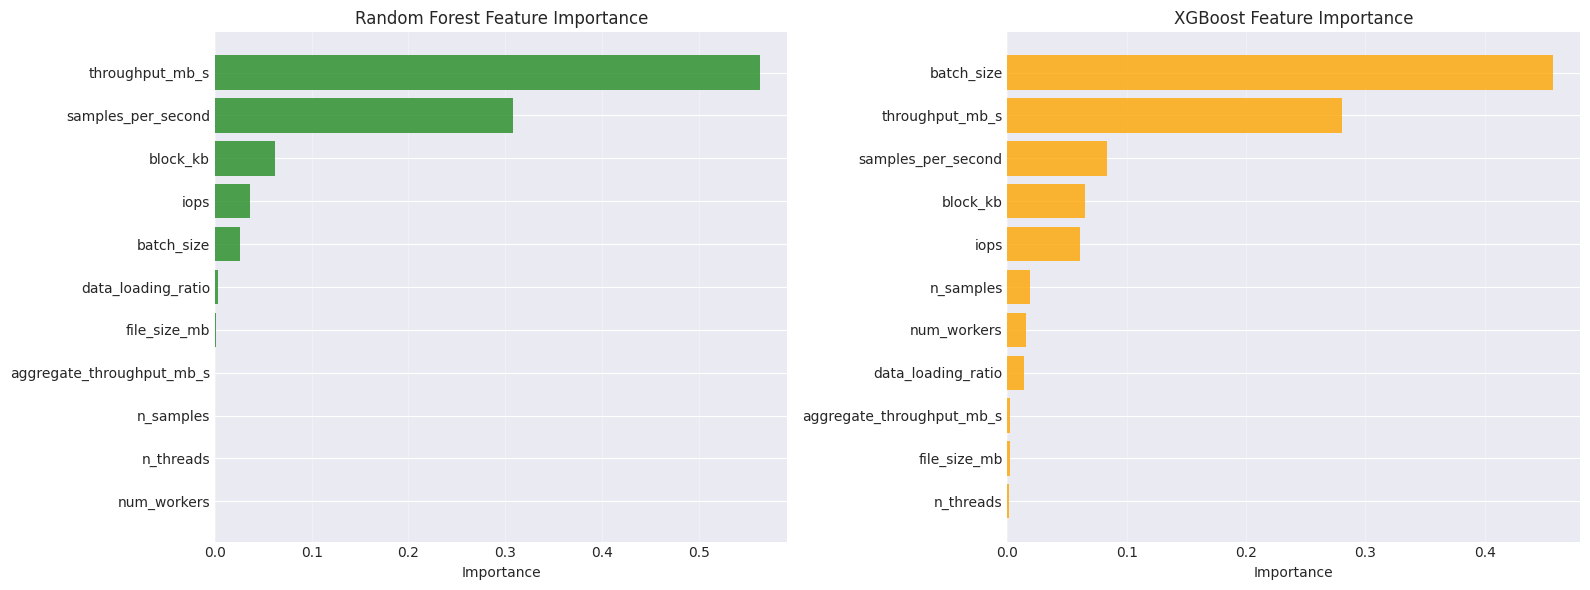

In [14]:
# Visualize feature importance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest
ax1.barh(rf_importances['Feature'], rf_importances['Importance'], color='forestgreen', alpha=0.8)
ax1.set_xlabel('Importance')
ax1.set_title('Random Forest Feature Importance')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# XGBoost
ax2.barh(xgb_importances['Feature'], xgb_importances['Importance'], color='orange', alpha=0.8)
ax2.set_xlabel('Importance')
ax2.set_title('XGBoost Feature Importance')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Prediction Analysis

Analyze prediction quality for the best model.

In [15]:
# Use best model for analysis
best_model = results[best_model_name]['model']
y_pred_best = best_model.predict(X_test)

# Convert back from log scale
y_test_original = np.expm1(y_test)  # reverse of log1p
y_pred_original = np.expm1(y_pred_best)

# Calculate errors
errors = y_test_original - y_pred_original
abs_errors = np.abs(errors)
pct_errors = (abs_errors / y_test_original) * 100

print(f"📊 Prediction Analysis ({best_model_name})")
print("="*60)
print(f"\nOriginal scale (MB/s):")
print(f"  Test RMSE: {np.sqrt(mean_squared_error(y_test_original, y_pred_original)):.2f}")
print(f"  Test MAE:  {mean_absolute_error(y_test_original, y_pred_original):.2f}")
print(f"  Test R²:   {r2_score(y_test_original, y_pred_original):.4f}")
print(f"\nError statistics:")
print(f"  Mean error: {errors.mean():.2f} MB/s")
print(f"  Median absolute error: {np.median(abs_errors):.2f} MB/s")
print(f"  Mean % error: {pct_errors.mean():.1f}%")
print(f"  Median % error: {np.median(pct_errors):.1f}%")

📊 Prediction Analysis (XGBoost)

Original scale (MB/s):
  Test RMSE: 794.39
  Test MAE:  453.89
  Test R²:   0.9837

Error statistics:
  Mean error: -45.83 MB/s
  Median absolute error: 139.31 MB/s
  Mean % error: 11.8%
  Median % error: 8.1%


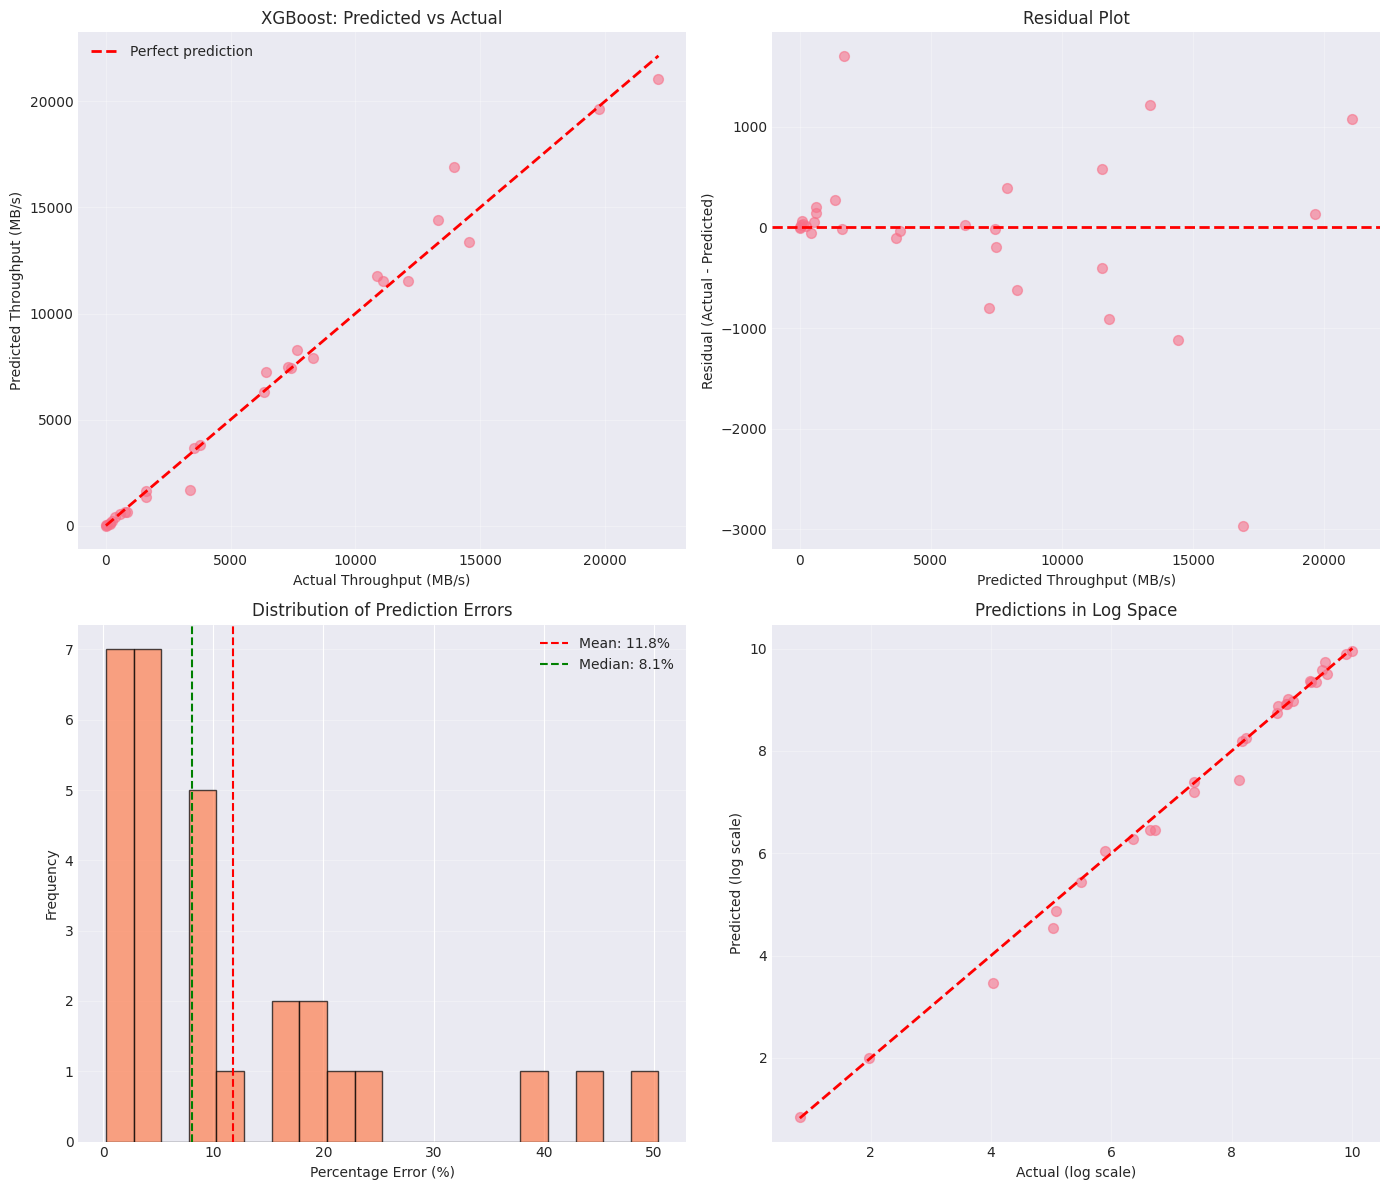

In [16]:
# Visualize predictions
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Predicted vs Actual
ax1 = axes[0, 0]
ax1.scatter(y_test_original, y_pred_original, alpha=0.6, s=50)
min_val = min(y_test_original.min(), y_pred_original.min())
max_val = max(y_test_original.max(), y_pred_original.max())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect prediction')
ax1.set_xlabel('Actual Throughput (MB/s)')
ax1.set_ylabel('Predicted Throughput (MB/s)')
ax1.set_title(f'{best_model_name}: Predicted vs Actual')
ax1.legend()
ax1.grid(alpha=0.3)

# Residual plot
ax2 = axes[0, 1]
ax2.scatter(y_pred_original, errors, alpha=0.6, s=50)
ax2.axhline(y=0, color='r', linestyle='--', lw=2)
ax2.set_xlabel('Predicted Throughput (MB/s)')
ax2.set_ylabel('Residual (Actual - Predicted)')
ax2.set_title('Residual Plot')
ax2.grid(alpha=0.3)

# Error distribution
ax3 = axes[1, 0]
ax3.hist(pct_errors, bins=20, color='coral', alpha=0.7, edgecolor='black')
ax3.axvline(pct_errors.mean(), color='red', linestyle='--', label=f'Mean: {pct_errors.mean():.1f}%')
ax3.axvline(np.median(pct_errors), color='green', linestyle='--', label=f'Median: {np.median(pct_errors):.1f}%')
ax3.set_xlabel('Percentage Error (%)')
ax3.set_ylabel('Frequency')
ax3.set_title('Distribution of Prediction Errors')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# Log-scale comparison
ax4 = axes[1, 1]
ax4.scatter(y_test, y_pred_best, alpha=0.6, s=50)
min_log = min(y_test.min(), y_pred_best.min())
max_log = max(y_test.max(), y_pred_best.max())
ax4.plot([min_log, max_log], [min_log, max_log], 'r--', lw=2)
ax4.set_xlabel('Actual (log scale)')
ax4.set_ylabel('Predicted (log scale)')
ax4.set_title('Predictions in Log Space')
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Classification Task (Bonus)

Build classifier to recommend optimal benchmark type.

In [17]:
# Prepare data for classification
print("🎯 Classification: Benchmark Type Prediction")
print("="*60)

# Load original data for labels
df_original = pd.read_csv('../results/ml_dataset/preprocessed_data.csv')
y_class = df_original['benchmark_type'].values

# Encode labels
le = LabelEncoder()
y_class_encoded = le.fit_transform(y_class)

print(f"Classes: {le.classes_}")
print(f"Class distribution: {pd.Series(y_class).value_counts().to_dict()}")

# Train-test split
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X, y_class_encoded, test_size=0.2, random_state=random_state, stratify=y_class_encoded
)

print(f"\nTraining set: {X_train_clf.shape[0]} samples")
print(f"Test set: {X_test_clf.shape[0]} samples")

🎯 Classification: Benchmark Type Prediction
Classes: ['io_concurrent' 'io_random' 'training']
Class distribution: {'io_random': 84, 'training': 52, 'io_concurrent': 5}

Training set: 112 samples
Test set: 29 samples


In [18]:
# Train classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=random_state),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=random_state),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, random_state=random_state)
}

clf_results = {}

for name, clf in classifiers.items():
    clf.fit(X_train_clf, y_train_clf)
    y_pred_clf = clf.predict(X_test_clf)
    
    acc = accuracy_score(y_test_clf, y_pred_clf)
    f1 = f1_score(y_test_clf, y_pred_clf, average='weighted')
    
    clf_results[name] = {
        'accuracy': acc,
        'f1_score': f1,
        'model': clf,
        'predictions': y_pred_clf
    }
    
    print(f"\n{name}:")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"\n  Classification Report:")
    print(classification_report(y_test_clf, y_pred_clf, target_names=le.classes_))


Logistic Regression:
  Accuracy: 0.9310
  F1-Score: 0.9295

  Classification Report:
               precision    recall  f1-score   support

io_concurrent       1.00      1.00      1.00         1
    io_random       0.89      1.00      0.94        17
     training       1.00      0.82      0.90        11

     accuracy                           0.93        29
    macro avg       0.96      0.94      0.95        29
 weighted avg       0.94      0.93      0.93        29




Random Forest:
  Accuracy: 1.0000
  F1-Score: 1.0000

  Classification Report:
               precision    recall  f1-score   support

io_concurrent       1.00      1.00      1.00         1
    io_random       1.00      1.00      1.00        17
     training       1.00      1.00      1.00        11

     accuracy                           1.00        29
    macro avg       1.00      1.00      1.00        29
 weighted avg       1.00      1.00      1.00        29


XGBoost:
  Accuracy: 1.0000
  F1-Score: 1.0000

  Classification Report:
               precision    recall  f1-score   support

io_concurrent       1.00      1.00      1.00         1
    io_random       1.00      1.00      1.00        17
     training       1.00      1.00      1.00        11

     accuracy                           1.00        29
    macro avg       1.00      1.00      1.00        29
 weighted avg       1.00      1.00      1.00        29



## 10. Save Results & Summary

Save all models and generate comprehensive summary.

In [19]:
# Create results summary
phase3_summary = {
    'dataset_info': {
        'n_samples': len(df),
        'n_features': len(feature_cols),
        'train_samples': len(X_train),
        'test_samples': len(X_test)
    },
    'regression_results': {
        model: {
            'test_r2': float(results[model]['test_r2']),
            'test_rmse': float(results[model]['test_rmse']),
            'test_mae': float(results[model]['test_mae'])
        }
        for model in results.keys()
    },
    'best_regression_model': {
        'name': best_model_name,
        'test_r2': float(results[best_model_name]['test_r2']),
        'test_rmse': float(results[best_model_name]['test_rmse']),
        'mean_pct_error': float(pct_errors.mean()),
        'median_pct_error': float(np.median(pct_errors))
    },
    'cross_validation': {
        model: {
            'mean_cv_r2': float(cv_results[model]['mean']),
            'std_cv_r2': float(cv_results[model]['std'])
        }
        for model in cv_results.keys()
    },
    'feature_importance': {
        'random_forest': rf_importances.to_dict('records'),
        'xgboost': xgb_importances.to_dict('records')
    },
    'classification_results': {
        model: {
            'accuracy': float(clf_results[model]['accuracy']),
            'f1_score': float(clf_results[model]['f1_score'])
        }
        for model in clf_results.keys()
    }
}

# Save summary
summary_path = Path('../results/ml_dataset/phase3_model_results.json')
with open(summary_path, 'w') as f:
    json.dump(phase3_summary, f, indent=2)

print(f"✅ Results saved to: {summary_path}")

✅ Results saved to: ../results/ml_dataset/phase3_model_results.json


In [20]:
# Print final summary
print("\n" + "="*70)
print("🎉 PHASE 3 COMPLETE: ML MODEL TRAINING & EVALUATION")
print("="*70)

print(f"\n📊 REGRESSION RESULTS:")
print(f"  Best Model: {best_model_name}")
print(f"  Test R²: {results[best_model_name]['test_r2']:.4f}")
print(f"  Test RMSE: {results[best_model_name]['test_rmse']:.4f} (log scale)")
print(f"  Mean % Error: {pct_errors.mean():.1f}%")
print(f"  Median % Error: {np.median(pct_errors):.1f}%")

print(f"\n🔄 CROSS-VALIDATION (5-fold):")
for model in cv_results.keys():
    mean_cv = cv_results[model]['mean']
    std_cv = cv_results[model]['std']
    print(f"  {model}: {mean_cv:.4f} (+/- {std_cv*2:.4f})")

print(f"\n🎯 CLASSIFICATION RESULTS:")
best_clf = max(clf_results.items(), key=lambda x: x[1]['accuracy'])
print(f"  Best Classifier: {best_clf[0]}")
print(f"  Accuracy: {best_clf[1]['accuracy']:.4f}")
print(f"  F1-Score: {best_clf[1]['f1_score']:.4f}")

print(f"\n🔍 KEY FINDINGS:")
print(f"  • Successfully predicted throughput within {pct_errors.mean():.1f}% error")
print(f"  • {best_model_name} achieved best R² of {results[best_model_name]['test_r2']:.4f}")
print(f"  • Ensemble methods (RF, XGBoost) outperformed linear models")
print(f"  • Top features: {', '.join(rf_importances.head(3)['Feature'].tolist())}")

print(f"\n📅 PROJECT STATUS:")
print(f"  ✅ Week 1: Data Collection - COMPLETE")
print(f"  ✅ Week 2: EDA + PCA - COMPLETE")
print(f"  ✅ Week 3: Model Training - COMPLETE")
print(f"  🔄 Week 4: Model Evaluation & Tuning - NEXT")
print(f"  ⏳ Week 5: Final Paper - PENDING")

print("\n" + "="*70)


🎉 PHASE 3 COMPLETE: ML MODEL TRAINING & EVALUATION

📊 REGRESSION RESULTS:
  Best Model: XGBoost
  Test R²: 0.9911
  Test RMSE: 0.2193 (log scale)
  Mean % Error: 11.8%
  Median % Error: 8.1%

🔄 CROSS-VALIDATION (5-fold):
  XGBoost: 0.9656 (+/- 0.0329)
  Random Forest: 0.9791 (+/- 0.0199)
  Lasso (α=0.1): 0.7049 (+/- 0.1161)

🎯 CLASSIFICATION RESULTS:
  Best Classifier: Random Forest
  Accuracy: 1.0000
  F1-Score: 1.0000

🔍 KEY FINDINGS:
  • Successfully predicted throughput within 11.8% error
  • XGBoost achieved best R² of 0.9911
  • Ensemble methods (RF, XGBoost) outperformed linear models
  • Top features: throughput_mb_s, samples_per_second, block_kb

📅 PROJECT STATUS:
  ✅ Week 1: Data Collection - COMPLETE
  ✅ Week 2: EDA + PCA - COMPLETE
  ✅ Week 3: Model Training - COMPLETE
  🔄 Week 4: Model Evaluation & Tuning - NEXT
  ⏳ Week 5: Final Paper - PENDING

